In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set()

In [3]:
benches = [ 'sieve' ]

# Alphabetical order
# pools = ['_async_fun', '_cc_fun', '_direct_fun', '_p2300_fun', '_tbb_fun']

# Performance order
pools = ['_cc_fun', '_unifex_fun', '_tbb_fun', '_direct_fun', '_async_fun', '_p2300_fun']

sizes = [100000000, 1000000000]

# If you just want to compare different frameworks on one block size, set blocks = [100]
blocks = [100]

# Otherwise, if you want to find the best block size for each framework, 
# set blocks to a list of different block sizes that you want to benchmark with
# blocks = [10, 100, 1000, 10000, 100000, 1000000]

#### Build the executables.  
The executables are built in their own build subdirectory, rather than the project-wide build subdirectory.  Change the cmake flags if you need specific options. 

In [4]:
os.system('mkdir build ; cd build ; cmake ../.. -DCMAKE_BUILD_TYPE=Release ; make -j 8');

-- The C compiler identification is AppleClang 13.1.6.13160021
-- The CXX compiler identification is AppleClang 13.1.6.13160021
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /Library/Developer/CommandLineTools/usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /Library/Developer/CommandLineTools/usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Looking for pthread.h
-- Looking for pthread.h - found
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Success
-- Found Threads: TRUE  
-- Checking for one of the modules 'hwloc'
-- IPO enabled
-- TBBBind build targets are disabled due to unsupported environment
-- Looking for C++ include coroutine
-- Looking for C++ include coroutine - not found
-

[ 87%] Building CXX object external/oneTBB/src/tbb/CMakeFiles/tbb.dir/task_dispatcher.cpp.o
[ 88%] Linking CXX executable ../bin/sieve_unifex_fun.exe
[ 88%] Built target sieve_unifex_fun.exe
[ 89%] Building CXX object external/oneTBB/src/tbbmalloc_proxy/CMakeFiles/tbbmalloc_proxy.dir/proxy.cpp.o
[ 90%] Building CXX object external/oneTBB/src/tbb/CMakeFiles/tbb.dir/task_group_context.cpp.o
[ 92%] Building CXX object external/oneTBB/src/tbb/CMakeFiles/tbb.dir/version.cpp.o
[ 93%] Building CXX object external/oneTBB/src/tbb/CMakeFiles/tbb.dir/queuing_rw_mutex.cpp.o
[ 94%] Linking CXX shared library ../../../../appleclang_13.1_cxx20_64_release/libtbbmalloc_proxy.dylib
[ 94%] Built target tbbmalloc_proxy
[ 96%] Linking CXX shared library ../../../../appleclang_13.1_cxx20_64_release/libtbb.dylib


ld: warning: cannot export hidden symbol typeinfo for tbb::detail::r1::unsafe_wait from CMakeFiles/tbb.dir/exception.cpp.o


[ 97%] Linking CXX executable ../bin/sieve_cc_fun.exe
[ 97%] Built target sieve_cc_fun.exe
[ 97%] Built target tbb
[ 98%] Building CXX object sieve/CMakeFiles/sieve_tbb_fun.exe.dir/sieve_tbb_fun.cpp.o
[100%] Linking CXX executable ../bin/sieve_tbb_fun.exe
[100%] Built target sieve_tbb_fun.exe


In [5]:
os.system('mkdir -p log')
for b in benches:
    for p in pools:
        bin = './build/bin/' + b + p + '.exe'
        for s in sizes:
            for bl in blocks:
                if (p == '_seq' and bl != 1000000):
                    continue
                if (s >= bl*1000):
                    args = str(s) + ' ' + str(bl)
                    logfile = './log/' +b + p + '_' + str(s) + '_' + str(bl) +'_out.txt'
                    os.system('/bin/rm -f ' + logfile)
                    for i in range(16):
                        os.system(bin + ' ' + args + ' >> ' + logfile)

In [6]:
for b in benches:
    for p in pools:
        for s in sizes:
            for bl in blocks:
                if (p == '_seq' and bl != 1000000):
                    continue
                if (s >= bl*1000):
                    listname = b + p + '_' + str(s) + '_' + str(bl)
                    exec(listname + ' = []')
                    logfile = './log/' + b + p + '_' + str(s) + '_' + str(bl) +'_out.txt'
                    with open(logfile) as log:
                        lines = log.readlines()
                        for line in lines:
                            if 'Time using char' in line:
                                l = line.split(':')
                                num = int(l[1])
                                exec(listname + '.append(num)')
                    exec(listname + '_mean = np.mean(' + listname + ')')
                    exec(listname + '_std = np.std(' + listname + ')')


In [7]:
def time_vs_block_size(name, mean_times, std_times, blocks):
    fig, ax = plt.subplots(figsize=(16,9))
    x_pos = np.arange(len(blocks))
    ax.bar(x_pos, mean_times, yerr=std_times, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Run time')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(blocks, rotation= 90)
    ax.set_title('Sieve Performance Comparison: ' + name)
    ax.yaxis.grid(True)

    # Save the figure and show
    plt.tight_layout()
    plt.savefig('./img/bar_plot_' + name + '_.png')
    plt.show()

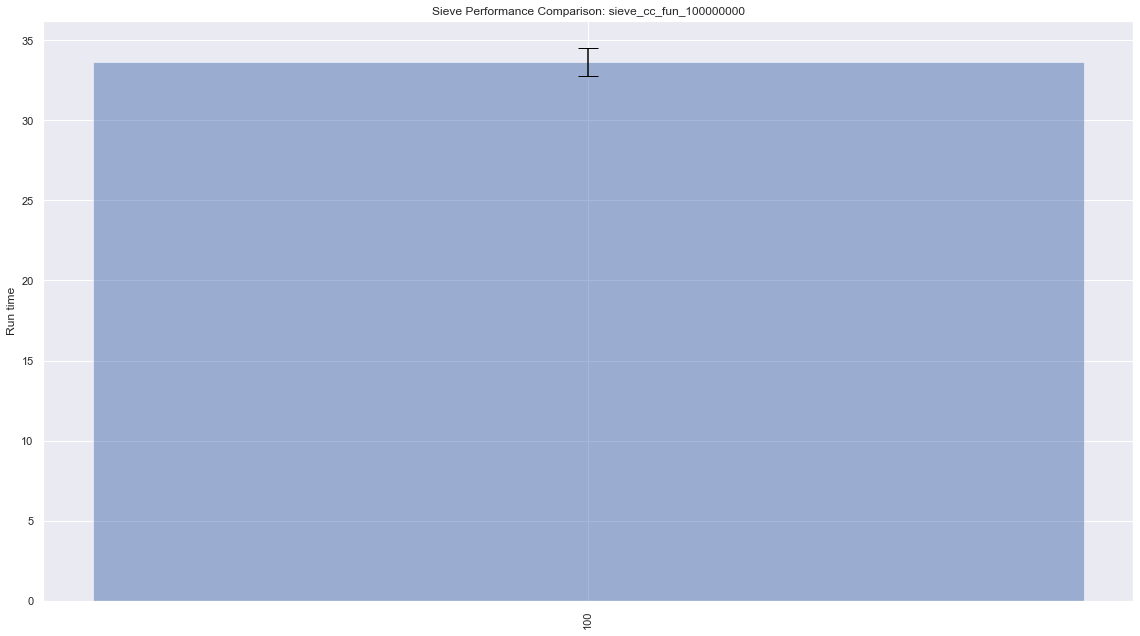

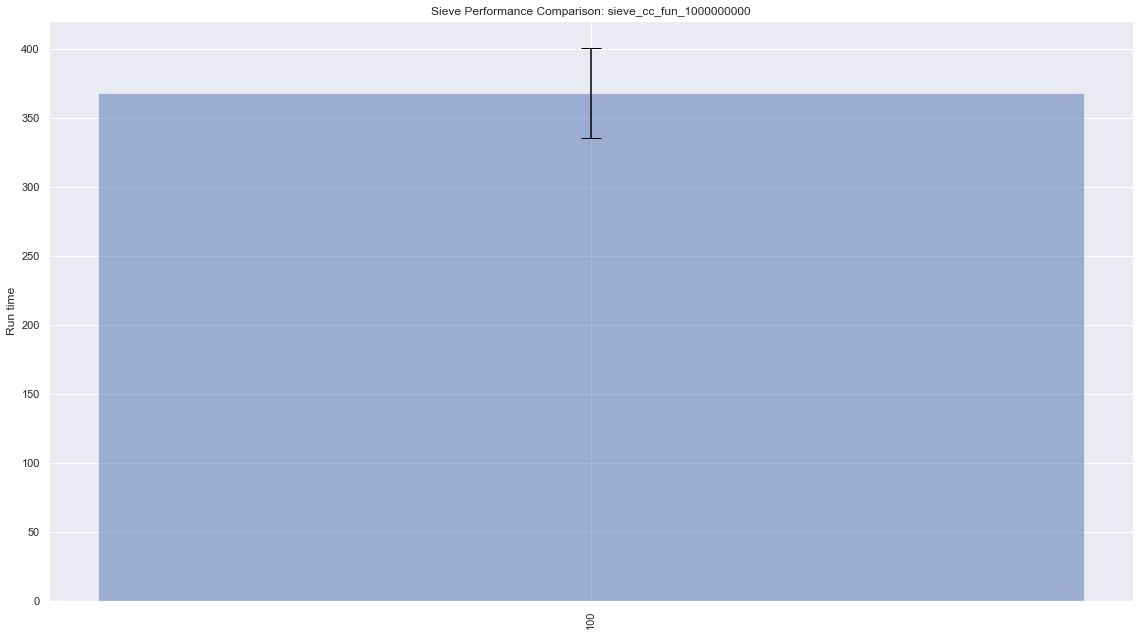

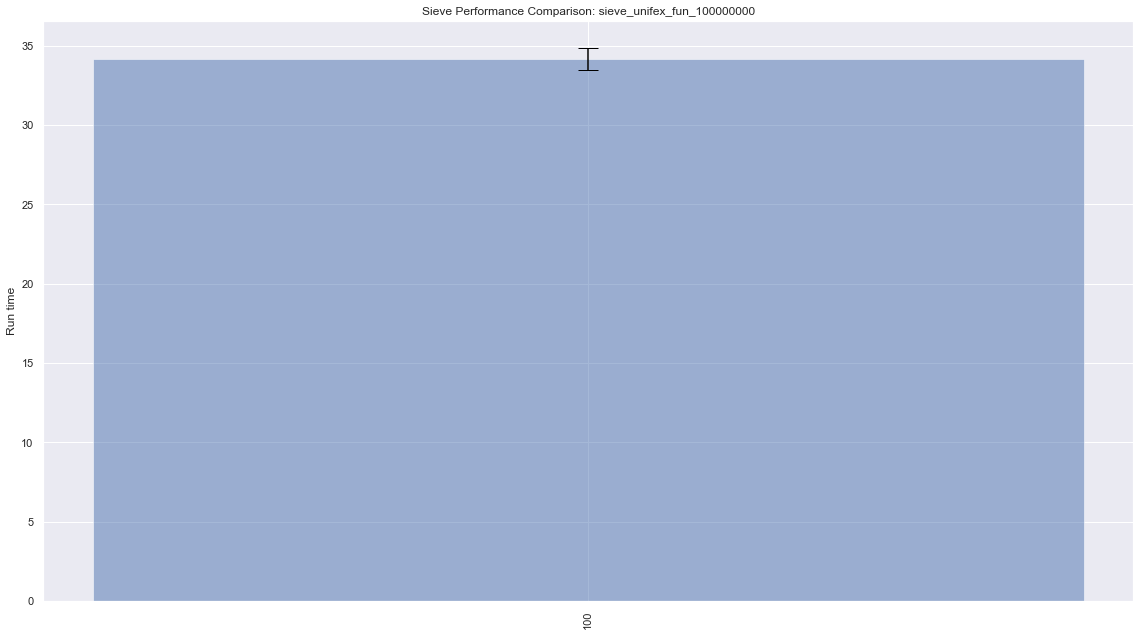

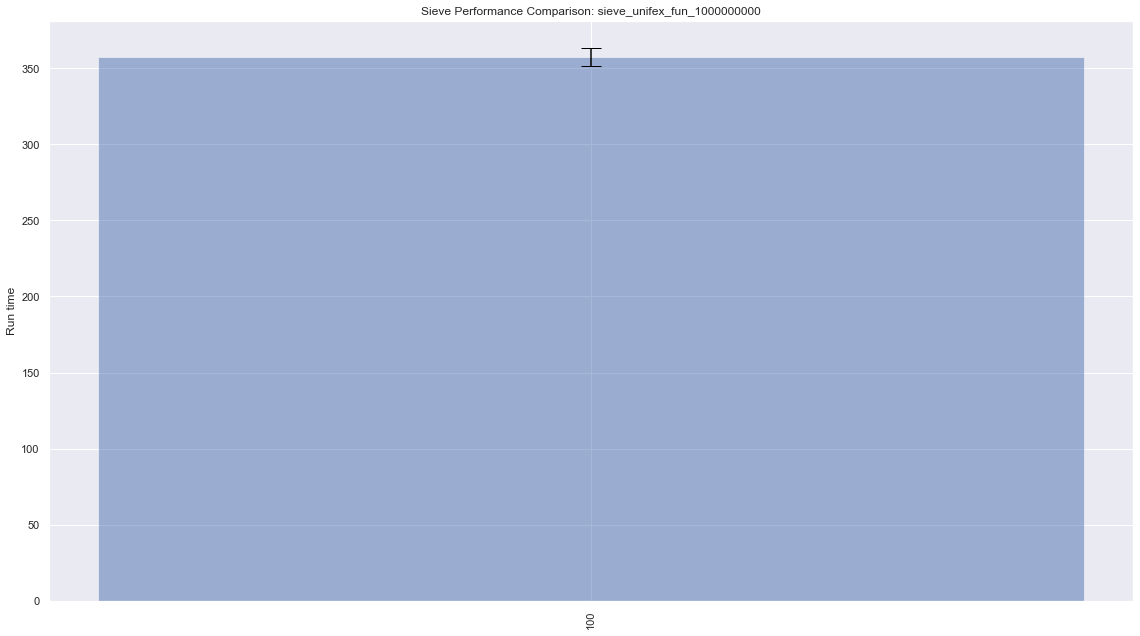

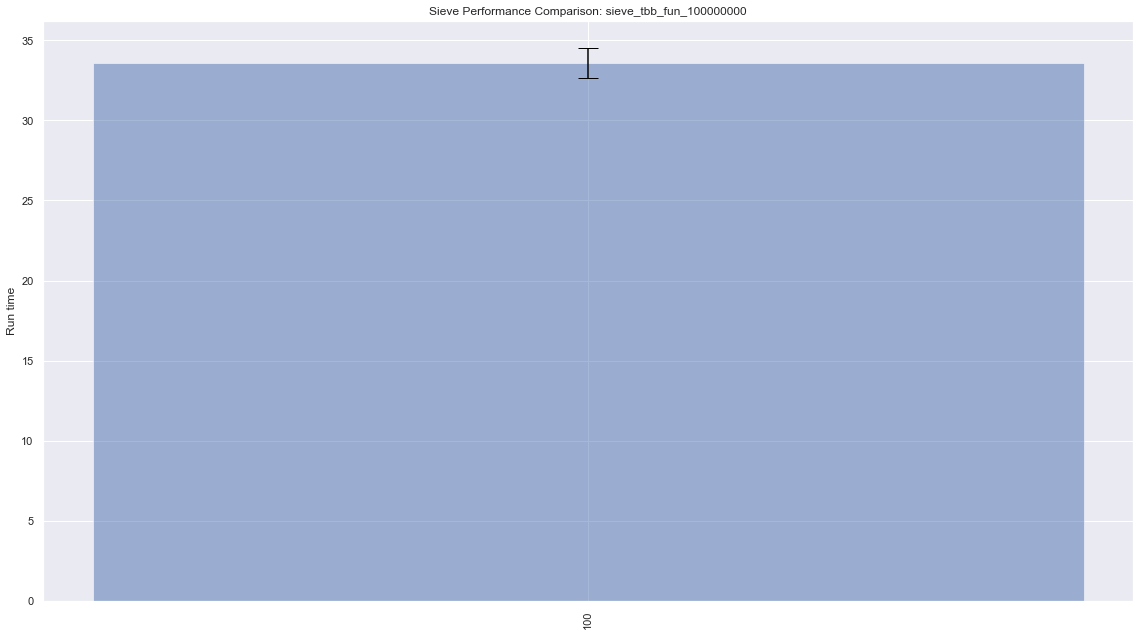

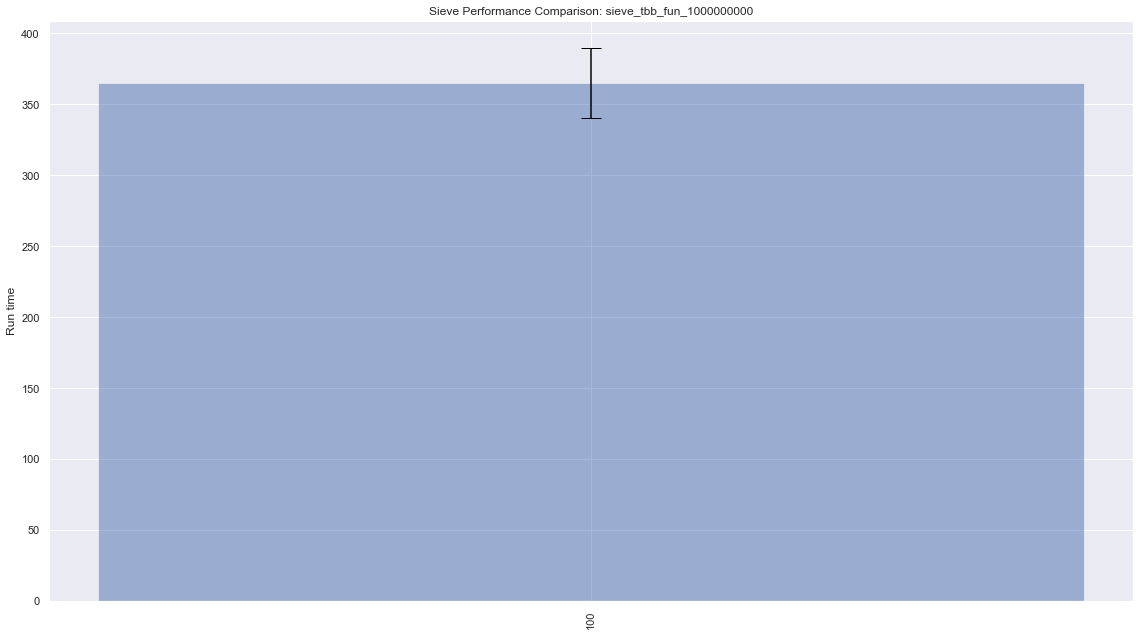

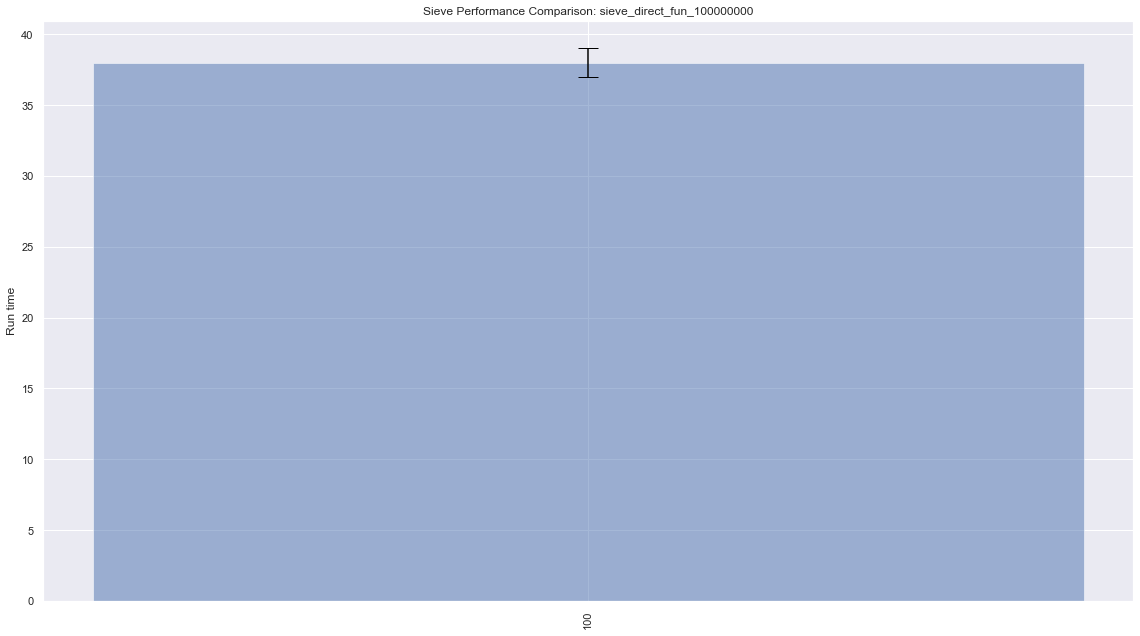

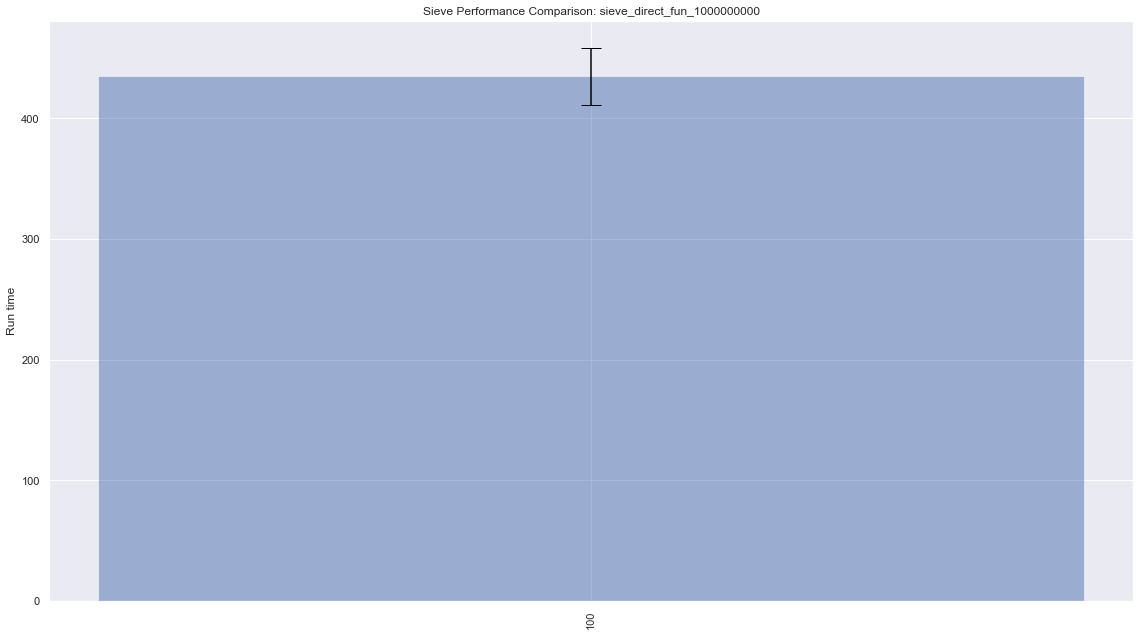

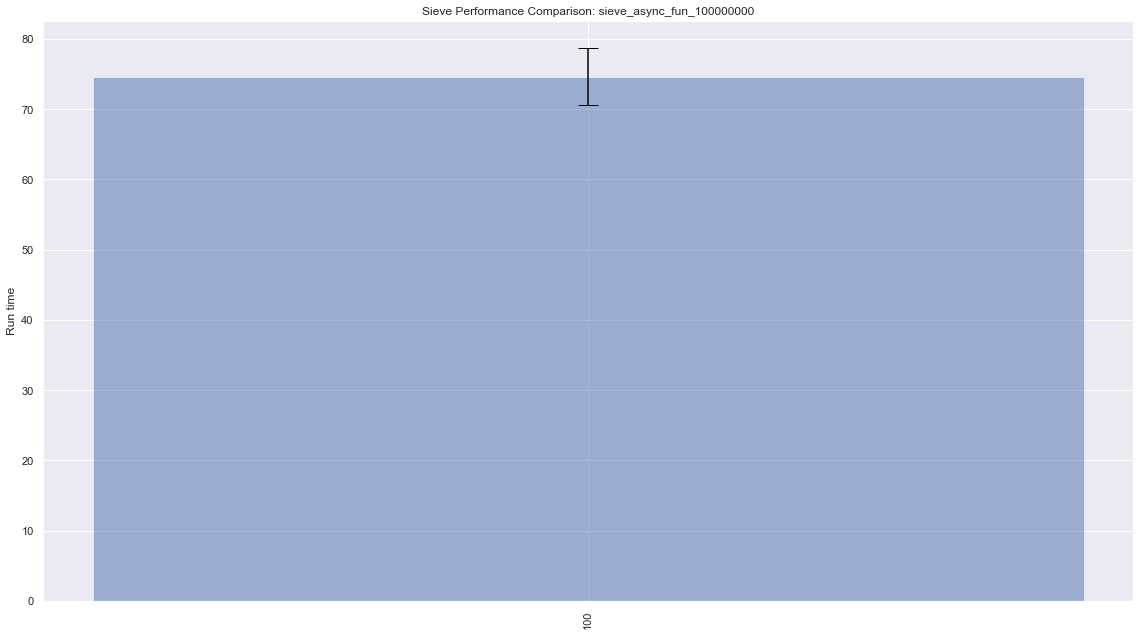

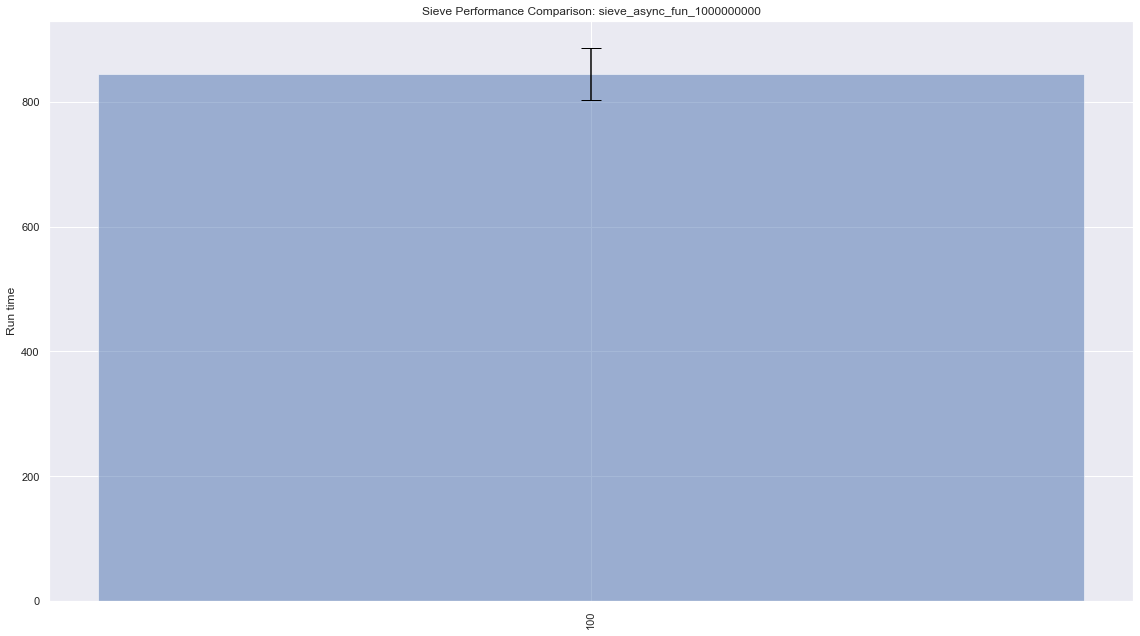

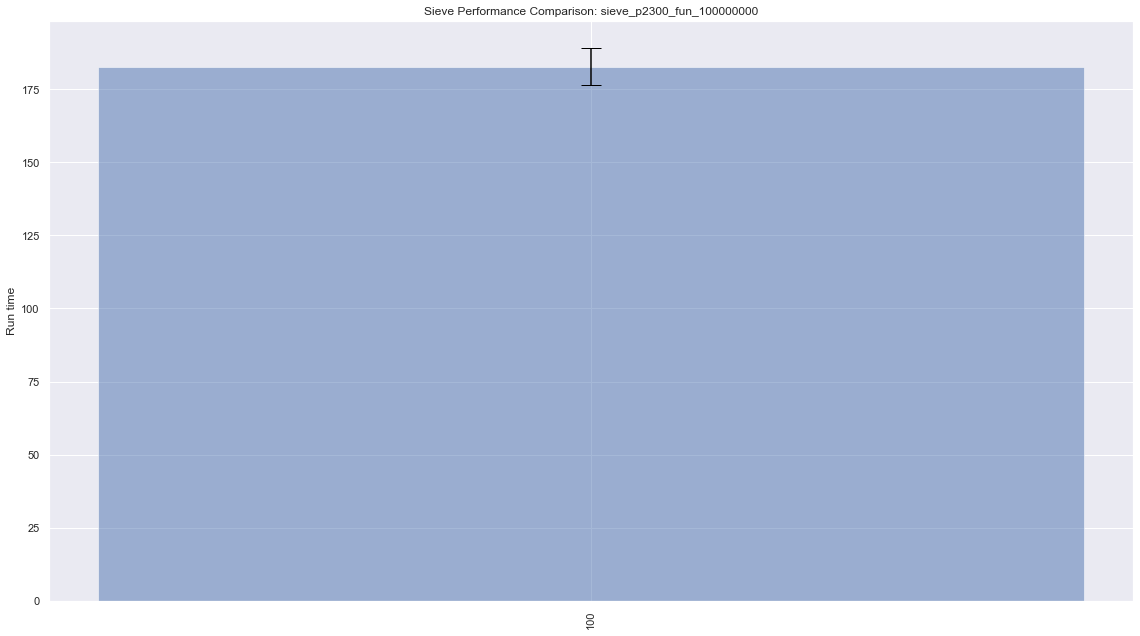

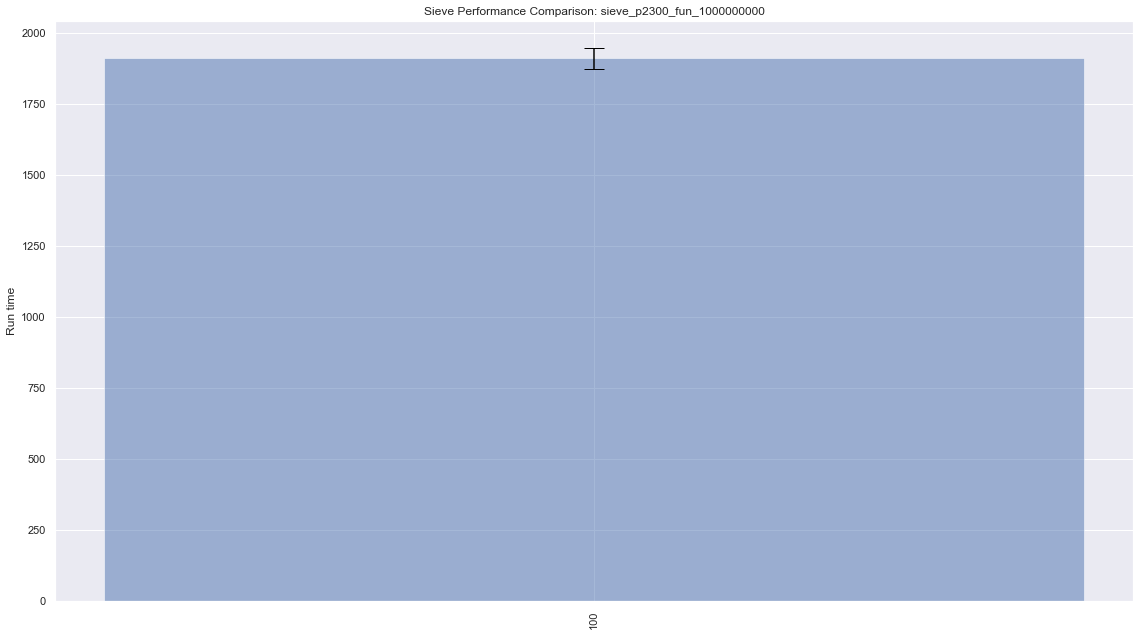

In [8]:
# For each framework, compare performance of different block sizes
os.system('mkdir -p img');
for b in benches:
    for p in pools:
        if (p == '_seq'):
            continue
        for s in sizes:
            listname = b + p + '_' + str(s)
            listname_mean = b + p + '_' + str(s) + '_mean'
            listname_std = b + p + '_' + str(s) + 'std'
            exec(listname_mean + ' = []')
            exec(listname_std + ' = []')
            xbl = []
            
            for bl in blocks:
                blockname_mean = b + p + '_' + str(s) + '_' + str(bl) + '_mean'
                blockname_std = b + p + '_' + str(s) + '_' + str(bl) + '_std'
                if (s >= bl*1000):
                    exec(listname_mean + '.append(' + blockname_mean + ')' )
                    exec(listname_std + '.append(' + blockname_std + ')' )
                    xbl.append(bl)
            exec('time_vs_block_size("' + listname + '", ' +listname_mean + ', ' + listname_std + ', ' + 'xbl)')
            

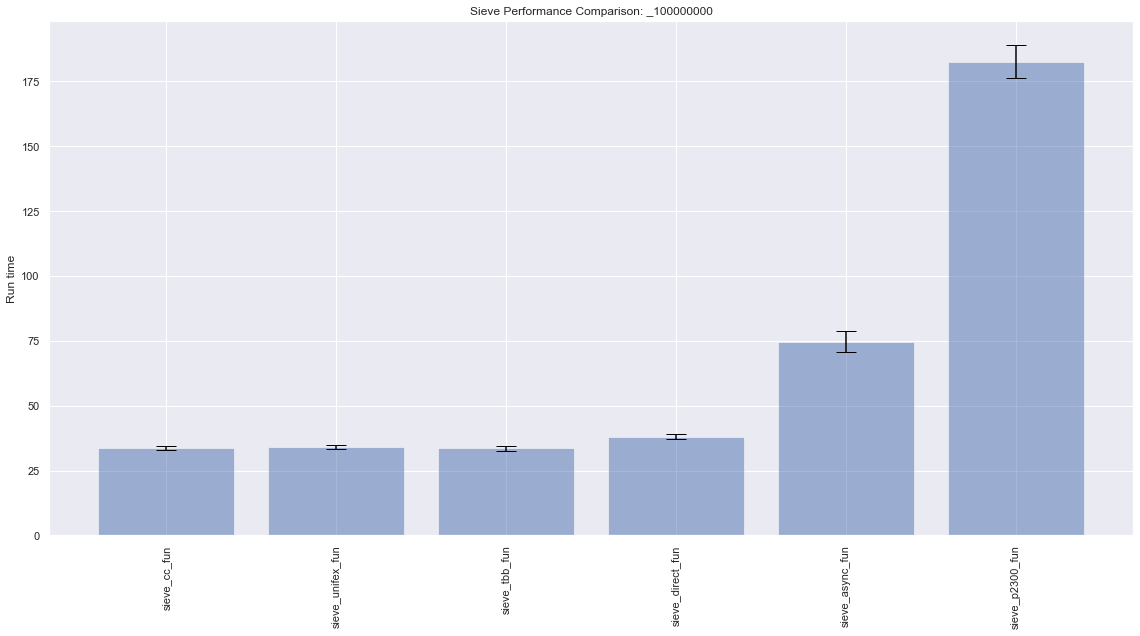

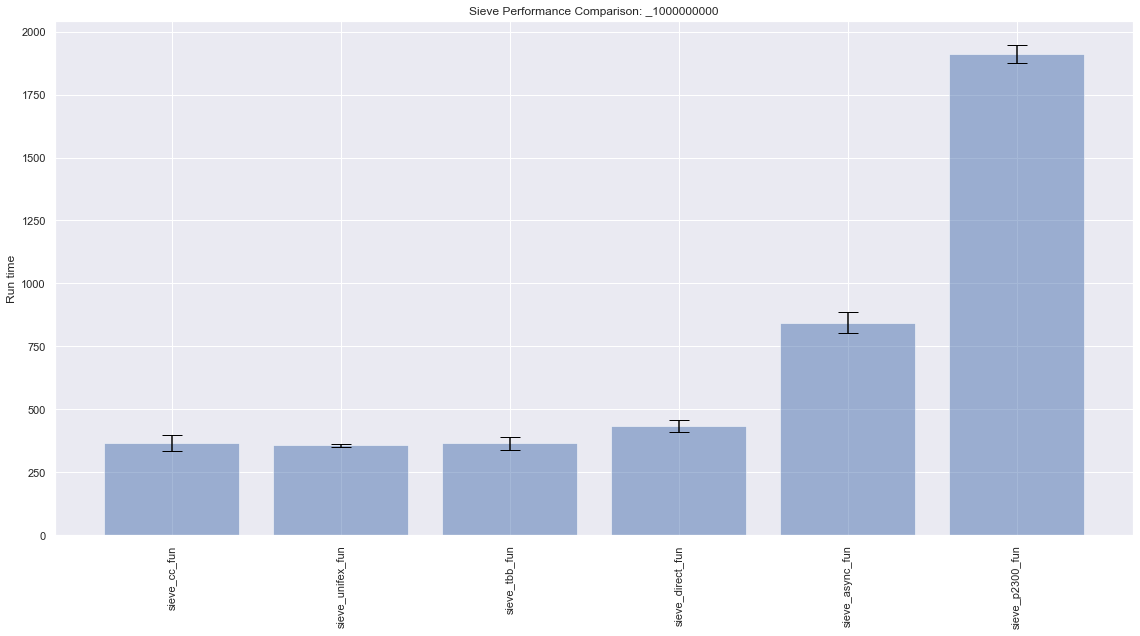

0

In [9]:
# Compare different frameworks performance at block size = 100
bl = 100
for s in sizes:
    
    listname = '_' + str(s)
    listname_mean = '_' + str(s) + '_mean'
    listname_std = '_' + str(s) + 'std'
    exec(listname_mean + ' = []')
    exec(listname_std + ' = []')
    xbl = []
    
    for b in benches:
        for p in pools:
            if (p == '_seq'):
                continue


            
            blockname_mean = b + p + '_' + str(s) + '_' + str(bl) + '_mean'
            blockname_std = b + p + '_' + str(s) + '_' + str(bl) + '_std'
            if (s >= bl*1000):
                exec(listname_mean + '.append(' + blockname_mean + ')' )
                exec(listname_std + '.append(' + blockname_std + ')' )
                xbl.append(b + p)
        exec('time_vs_block_size("' + listname + '", ' +listname_mean + ', ' + listname_std + ', ' + 'xbl)')
os.system('/bin/cp ./img/bar_plot__1000000000_.png ./img/bar_plot__100000000_.png ../img')